In [53]:
import pandas as pd

In [54]:
%load_ext autoreload
%autoreload 1
%aimport config, utils
from config import model_map, method_map 
from config import heat_map_font_sizes as font_sizes
from utils import heatmap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import wandb
run = wandb.init()
artifact = run.use_artifact('jonros/jailbreaks_memory/memory_metrics_checkpoint-65aecc71:v19', type='memory_checkpoint')
artifact_dir = artifact.download()

wandb:   1 of 1 files downloaded.  


In [56]:
from pathlib import Path

In [57]:
artifact_dir = Path(artifact_dir)

In [58]:
import glob

dfs = []
csv_files = glob.glob(str(artifact_dir / "**/*.csv"), recursive=True)
for csv_file in csv_files:
    dfs.append(pd.read_csv(csv_file))

df = pd.concat(dfs)
df.head()




,benchmark,model,method_combo,num_samples,total_gen_time,avg_gen_time,initial_cuda_memory_gb,initial_cuda_reserved_gb,post_load_cuda_memory_gb,post_load_cuda_reserved_gb,final_cuda_memory_gb,final_cuda_reserved_gb,peak_cuda_memory_gb,post_clear_cuda_memory_gb,post_clear_cuda_reserved_gb,memory_increase_gb,reserved_increase_gb,memory_cleaned_gb,reserved_cleaned_gb
0,malicious-300t,phi-4,prefixinjection-3,100,37.968443,0.379684,0.000031,0.001953,27.383616,27.384766,27.414866,31.113281,29.940963,0,0,0,0,0,0
1,malicious-300t,phi-4,hiddenlayerinjection,100,8.735010,0.087350,0.031281,0.033203,27.414866,27.416016,27.414866,37.898438,36.262565,0,0,0,0,0,0
2,malicious-300t,phi-4,diffinmeans,100,85.157727,0.851577,0.031281,0.033203,37.769304,65.308594,37.769304,65.394531,40.431504,0,0,0,0,0,0
3,malicious-300t,phi-4,outputaware-temperature,100,129.572580,1.295726,0.031281,0.033203,27.414866,27.416016,27.414866,32.970703,29.657421,0,0,0,0,0,0
4,malicious-300t,phi-4,baseline,100,43.293045,0.432930,0.031281,0.033203,27.414866,27.416016,27.414866,32.878906,29.632102,0,0,0,0,0,0


In [59]:
df["memory_usage"] = df["post_load_cuda_reserved_gb"] - df["initial_cuda_memory_gb"]

In [60]:
memory_df = df[["method_combo", "model", "memory_usage"]]

In [61]:
memory_df

,method_combo,model,memory_usage
0,prefixinjection-3,phi-4,27.384735
1,hiddenlayerinjection,phi-4,27.384735
2,diffinmeans,phi-4,65.277313
3,outputaware-temperature,phi-4,27.384735
4,baseline,phi-4,27.384735
5,prefixinjection-3,gemma-2-9b-it,17.214813
6,hiddenlayerinjection,gemma-2-9b-it,17.214813
7,diffinmeans,gemma-2-9b-it,39.134735
8,outputaware-temperature,gemma-2-9b-it,17.214813
9,baseline,gemma-2-9b-it,17.214813


In [62]:
from scipy.stats import norm
import numpy as np


def ci_error(series, alpha=0.05):
    z = norm.ppf(1 - alpha/2)
    return z * series.std(ddof=1) / np.sqrt(series.count())
ci_error.__name__ = 'ci_error'

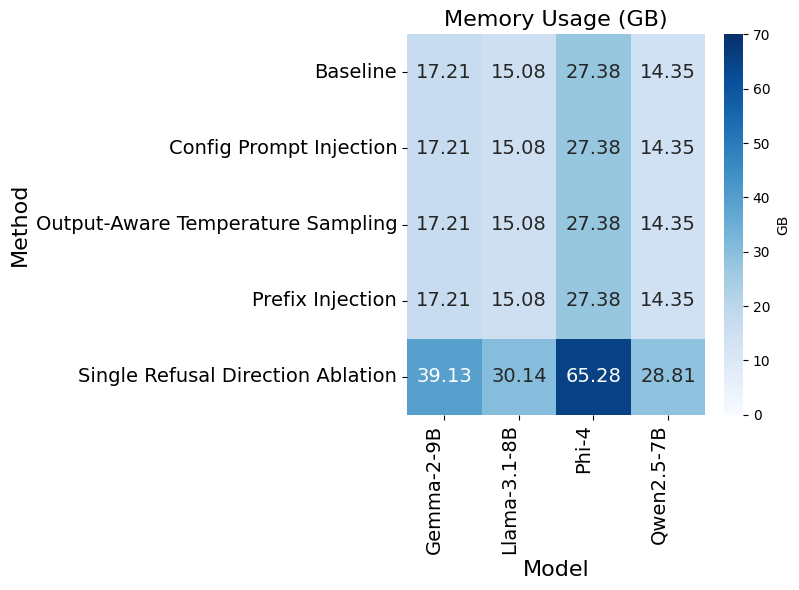

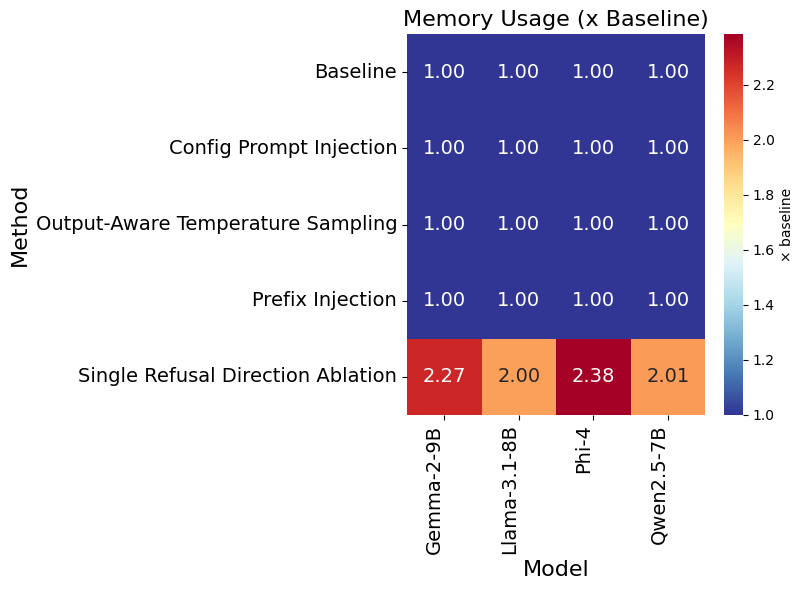

In [63]:
from matplotlib import pyplot as plt
import seaborn as sns

metric_map = {
    "memory_usage"        : {"name":"Memory Usage", "unit":"GB", "ylim":(0, 70)},
}

metric_map_normalized = {
    "memory_usage"        : {"name":"Memory Usage", "unit":"GB", "ylim":(0, 4)},
}

percent_metrics = {
    m for m, props in metric_map.items() if props["unit"] == "%"
}

metrics = ["memory_usage"]

df = df.rename(columns={"method_combo": "method"})

run_means = df.groupby(['method', 'model']).agg({
    **{metric: 'mean' for metric in metrics},
})

run_means = run_means.rename(index=method_map, level="method")
run_means = run_means.rename(index=model_map, level="model")

grouped_df = run_means.groupby(['method', 'model']).agg({
    **{metric: ['mean', 'std', 'count', ci_error] for metric in metrics},
})

metric = "memory_usage"
transformation = 1
output_dir = Path(f"../report/figures/cost")
fig_dir = Path(f"{output_dir}")
fig_dir.mkdir(parents=True, exist_ok=True)


heatmap(
    grouped_df,
    metric,
    "mean",
    cmap="Blues",
    transformation=transformation,
    fig_dir=fig_dir,
    title=f"{metric_map[metric]['name']} (GB)",
    unit=metric_map[metric]["unit"],
    ylim=metric_map[metric]["ylim"],
    font_sizes=font_sizes
)

# Generate normalized heatmap (relative to baseline)
heatmap(
    grouped_df,
    metric,
    "mean",
    cmap="RdYlBu_r",
    transformation=1,
    fig_dir=fig_dir,
    title=f"{metric_map_normalized[metric]['name']} (x Baseline)",
    unit="× baseline",
    font_sizes=font_sizes,
    #ylim=metric_map_normalized[metric]["ylim"],
    normalize_by_baseline=True
)